
# NLP Course Assignment Epsiode 1
## Question 3 a)

The goal of this exercise is to compare two differen simple approaches to sentiment classification of movie reviews.

The movie review dataset used in this task is the polarity dataset v2 from Bo Pang and Lillian Lee: http://www.cs.cornell.edu/people/pabo/movie-review-data/

The code for this task makes use of the following packages: scikit-learn, NLTK, pandas, glob, matplotlib and wordcloud

In [2]:
%matplotlib inline
import pandas as pd
from glob import glob
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

$\pagenumbering{gobble}$

The movie reviews are already divided into positive and negative reviews. They are loaded and stored in a dataframe, where each review is assigned a 'pos' or 'neg' label.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  2000 non-null   object
 1   text       2000 non-null   object
 2   label      2000 non-null   object
dtypes: object(3)
memory usage: 47.0+ KB


None

pos    1000
neg    1000
Name: label, dtype: int64

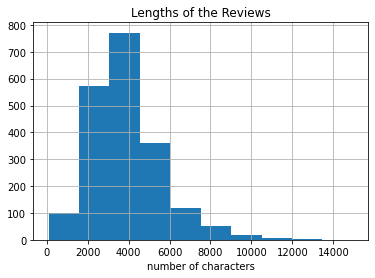

In [3]:
# relative path to the sentiment files
path_sent = 'review_polarity/txt_sentoken'

# dataframe to store all reviews
reviews_df = pd.DataFrame(columns=['file_name', 'text', 'label'])

# get negative reviews
filenames_neg = glob(path_sent + '/neg/*.txt')

for file_name in filenames_neg:
    file = open(file_name)
    text = file.read()
    reviews_df = reviews_df.append({
        'file_name': file_name, 'text': text, 'label': 'neg'},
        ignore_index=True)
    file.close()

# get positive reviews
filenames_pos = glob(path_sent + '/pos/*.txt')

for file_name in filenames_pos:
    file = open(file_name)
    text = file.read()
    reviews_df = reviews_df.append({
        'file_name': file_name, 'text': text, 'label': 'pos'},
        ignore_index=True)
    file.close()

display(reviews_df.info())
display(reviews_df['label'].value_counts())

fig, ax = plt.subplots()
reviews_df['text'].apply(len).hist(axes=ax)
ax.set(xlabel='number of characters', title='Lengths of the Reviews')
plt.show()

The dataset consists of 2000 movie reviews, has no missing values and is balanced. The reviews have a variety of lengths, shown in the histogram above.
400 reviews are randomly selected and hold out as a test set to evaluate the performance of the created model.

In [4]:
train_reviews, test_reviews, train_labels, test_labels = train_test_split(
    reviews_df['text'].to_numpy(),
    reviews_df['label'].to_numpy(),
    test_size=400,
    random_state=42
    )

The reviews are stored as strings. Before features can be extracted, the following preprocessing steps are performed:
* tokenization
* removal of non-alphabetical tokens
* removal of common stopwords
* lemmatization

In [5]:
def preprocess_review(string):

    # tokenize input
    tokens = word_tokenize(string.lower())

    # remove non-alphabetical tokens
    tokens_alpha = [w for w in tokens if w.isalpha()]

    # remove stopwords
    tokens_no_stops = [w for w in tokens_alpha
                       if w not in stopwords.words('english')]

    # lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens_lemma = [lemmatizer.lemmatize(w) for w in tokens_no_stops]

    return tokens_lemma


train_reviews_pre = [preprocess_review(review) for review in train_reviews]
test_reviews_pre = [preprocess_review(review) for review in test_reviews]

A fun way to visualize the tokens is with a word cloud:

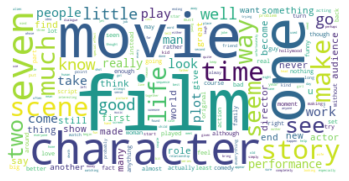

In [6]:
cloud = WordCloud(background_color='white').generate(
    ' '.join([' '.join(el) for el in (train_reviews_pre + test_reviews_pre)])
)
plt.figure()
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

(i) For the first model, a lexicon-based classifier, the sentiment lexicon of Bing Liu is used: https://www.kaggle.com/nltkdata/opinion-lexicon

The lexicons for positive and negative words are loaded seperately. The words are lemmatized in the same way the reviews are during preprocessing, to assure comparability.

In [7]:
def get_lex(path_lex):

    # read lexicon and transform to list
    lex = pd.read_csv(
        path_lex,
        comment=';',
        header=None
        ).to_numpy().ravel().tolist()

    # lemmatize lexicon
    lemmatizer = WordNetLemmatizer()
    lex_lemma = [lemmatizer.lemmatize(w) for w in lex]

    return lex_lemma


lex_pos = get_lex('opinion_lexicon/positive-words.txt')
lex_neg = get_lex('opinion_lexicon/negative-words.txt')

The classification process is simply counting negative and positive words in each review. No training is needed. Therfore this process can directly be performed on the test set and be evaluated on the ground truth. As evaluation metric accuracy $\left( \frac{TP + TN}{TP+TN+FP+FN} \right)$ and the F<sub>1</sub>-score $\left( \frac{2 TP}{2 TP + FP + FN} \right)$ are used.

In [8]:
def classifiy_lemma(lemma, lex_pos, lex_neg):

    pos_count = sum([1 for w in lemma if w in lex_pos])
    neg_count = sum([1 for w in lemma if w in lex_neg])

    return 'pos' if pos_count >= neg_count else 'neg'


test_labels_pred = [classifiy_lemma(
    review,
    lex_pos,
    lex_neg)
    for review in test_reviews_pre]

# convert labels to 1 for positive and 0 for negative
label_dict = {'pos': 1, 'neg': 0}
test_labels_01 = [label_dict.get(i, i) for i in test_labels]
test_labels_pred_01 = [label_dict.get(i, i) for i in test_labels_pred]

# calculate accuary and F1 score on test set
display('Accuracy of lexicon based classification: {acc:.4f}'
      .format(acc=accuracy_score(test_labels_01, test_labels_pred_01)))
display('F1-score of lexicon based classification: {f1:.4f}'
      .format(f1=f1_score(test_labels_01, test_labels_pred_01)))

'Accuracy of lexicon based classification: 0.6800'

'F1-score of lexicon based classification: 0.6718'

(ii) As second model a discriminative classifier is trained on the test set. The tokens are vectorized with their term frequency - inverse document frequency (tfidf). These are then used as fetures for a (regularized) logistic regression model. The performance is again evaluated on the held out test set.

In [9]:
# reviews are already tokenized, therefore a dummy function
# is passed to the vectorizer
def dummy_tokenizer(text):
    return text


# Tfidf vectorization of the training and test reviews
vectorizer = TfidfVectorizer(
    lowercase=False,
    tokenizer=dummy_tokenizer,
    token_pattern=None
    )
vectorizer.fit(train_reviews_pre)
train_reviews_tfidf = vectorizer.transform(train_reviews_pre)
test_reviews_tfidf = vectorizer.transform(test_reviews_pre)

# convert labels to 1 for positive and 0 for negative
label_dict = {'pos': 1, 'neg': 0}
train_labels_01 = [label_dict.get(i, i) for i in train_labels]
test_labels_01 = [label_dict.get(i, i) for i in test_labels]

# use logistic regression to predict the labels of the test reviews
clf = LogisticRegression(C=10)
clf.fit(train_reviews_tfidf, train_labels_01)
test_labels_pred_01 = clf.predict(test_reviews_tfidf)

# calculate accuary and F1 score on test set
display('Accuracy of discriminative classification: {acc:.4f}'
      .format(acc=accuracy_score(test_labels_01, test_labels_pred_01)))
display('F1-score of discriminative classification: {f1:.4f}'
      .format(f1=f1_score(test_labels_01, test_labels_pred_01)))

'Accuracy of discriminative classification: 0.8475'

'F1-score of discriminative classification: 0.8530'

(iii) The performance of the lexicon-based classifier is already good. An accuracy of 68% is clearly better than a coinflip, but not overwhelming. The trained logistic regression, with an accuracy of almost 85%, performes significantly better. This is due to the fact, that the discriminative approach is trained on a task-specific vocabulary and can also take into account whether certain words appear in combination with other words. The lexicon based approach on the other hand has a very general vocabulary and just count word occurence.
Both methods don't take into account the context or the order of the words. The discriminative method could easily be expanded in this direction, by adding n-grams to the feature space.

The lexcion-based approach might also have its advantages. It is not dependent on (correctly) labeled training data, which might be expensive to get and might also generalize better to other similar tasks.

To better evaluate the classifiers, they could be evaluated on different test sets (cross-validation). Further could they be tested on a different task. E.g. they could be evaluated on car reviews (without retraining). The lexicon based approach should keep its performance, while the discriminative approach might decrease in accuracy.